# Modelling firing fields during the search path 

## Modelling 

* Which behavioral variable best predict the firing rate of the neuron during the search path?

We are predicting the firing rate as it is the common variable that can be compared across behavioral variables. 
We can then compared the mse across behavioral conditions.
We should only take this as one of several indicators for a conclusion.


* We need a split the data into training and test sets.
* Use mean square error as a measure of prediction accuracy.
* Pick one model that can fit the tuning curve of the neurons.




In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList,pose_file_extension = ".pose_kf.npy")

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 40 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 40/40 [00:27<00:00,  1.48it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
%%time
myProjectWithTrials = loadMyProjectWithTrials(myProject)
prepareSessionsForSpatialAnalysisProject(sSesList,myProjectWithTrials.sessionList,pose_file_extension = ".pose_kf.npy")

Loading: /adata/projects/autopi_ca1/results/myProjectWithTrials.pickle
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 40/40 [00:25<00:00,  1.54it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict
CPU times: user 16.3 s, sys: 7.98 s, total: 24.3 s
Wall time: 49.6 s


In [3]:
fn=myProject.dataPath+"/results/searchFields.pickle"
with open(fn, 'rb') as handle:
    searchFields = pickle.load(handle)

In [4]:
fn=myProject.dataPath+"/results/searchIFRDict.pickle"
with open(fn, 'rb') as handle:
    searchIFR = pickle.load(handle)

## Example with one field

In [5]:
cellId="mn9686-27102021-0106_36"
light="dark"
pathType="searchToLeverPath"

searchFields[searchFields.cellId==cellId]

,cellId,light,vari,peak_locs,min_left,min_right,peak_heights,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips,peak_ratio_left,peak_ratio_right
0,mn9686-27102021-0106_36,dark,distance,26.00,3.023547,4.111538,34.251120,2.037808,22.00,30.00,4.997708,33.232216,23.241713,28.239421,0.088276,0.120041
0,mn9686-27102021-0106_36,dark,iTime,0.75,4.610190,1.880204,29.643975,2.397256,0.50,1.00,0.283886,28.445347,0.568731,0.852618,0.155519,0.063426
0,mn9686-27102021-0106_36,dark,distanceProp,0.15,6.434743,4.618221,22.525160,1.212320,0.05,0.25,0.096386,21.919000,0.127586,0.223972,0.285669,0.205025


In [6]:
from sklearn.model_selection import train_test_split
from neuronAutopi import NeuronAutopi
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


def mse_ifr_prediction(trainIfr,trainBeha,testIfr,testBeha,var=["distance"]):
    """
    Function to predict the IFR from a behavioral variable using a multi-layer peceptron model
    
    A train and test sets are used. 
    Returns the MSE for the train and test set is returned
    """
    yTrain = trainIfr
    XTrain = trainBeha[var].to_numpy().reshape(-1,len(var))
    yTest = testIfr
    XTest = testBeha[var].to_numpy().reshape(-1,len(var))

    # remove entries with nan in behavioral data, ifr does not have nans
    keep= ~np.isnan(XTrain[:,0])
    XTrain = XTrain[keep,:]
    yTrain = yTrain[keep]
    keep= ~np.isnan(XTest[:,0])
    XTest = XTest[keep,:]
    yTest = yTest[keep]
    
    # train a Multi-layer Perceptron regressor.
    regr = MLPRegressor(random_state=1,hidden_layer_sizes=(6,12,6), max_iter=5000).fit(XTrain, yTrain)

    y_pred_train = regr.predict(XTrain)
    mse_train = mean_squared_error(yTrain, y_pred_train)
    y_pred_test = regr.predict(XTest)
    mse_test = mean_squared_error(yTest, y_pred_test)
    
    return mse_train, mse_test


def field_IFR_prediction(cellId,light,pathType,myProjectWithTrial,sSesList, behavioralVariables=[["distance"],["iTime"]]):
    """
    Function to see how well behavioral variables can predict the IFR of a neuron
    
    """

    sesName = cellId.split("_")[0]
    cluNo =  cellId.split("_")[1]
    ses = myProjectWithTrials.getSession(sesName)
    sSes = [ses for ses in sSesList if ses.name==sesName][0]
    # load raw data from file
    ifr, navs, inav = load_ifr_behavior(ses,verbose=False)
    
    # select the navPaths of the relevant type
    selNavs= navs[(navs.light==light)&(navs.type==pathType)]
    
    # get the IFR of the neuron
    cluIndex  = np.where(np.array([n.name for n in sSes.cg.neuron_list])==cluNo)[0][0]
    rate = ifr[0][cluIndex,:]
    time = ifr[1]
    
    # split the data into training and test sets
    train, test = train_test_split(selNavs.name, test_size=0.33, random_state=42)
    trainInst = inav[inav.name.isin(train)]
    trainSum = selNavs[selNavs.name.isin(train)]

    testInst = inav[inav.name.isin(test)]
    testSum = selNavs[selNavs.name.isin(test)]

    
    # get behavioral data and IFR for the test and train sets, using our neuronAutopi class
    trainNa = NeuronAutopi(name="train",ifr=(rate,time),navPathSummary=trainSum,iNavPath=trainInst,trialElectro=None)
    testNa = NeuronAutopi(name="test",ifr=(rate,time),navPathSummary=testSum,iNavPath=testInst,trialElectro=None)
    trainIfr, trainBeha = trainNa.getSingleNavPathData(navPathNames = train)
    testIfr, testBeha = testNa.getSingleNavPathData(navPathNames = test)

    res = pd.DataFrame()
    res = pd.DataFrame({"cellId":[cellId],"light":[light],"pathType":[pathType]})
    res["test_n"] = [testSum.shape[0]]
    res["train_n"] = [trainSum.shape[0]]
        
    ## model the neuron using the train set and predict the ifr test
    for behav in behavioralVariables:
        mse_train,mse_test = mse_ifr_prediction(trainIfr,trainBeha,testIfr,testBeha,var=behav)
        res["{}_mse_train".format('-'.join(behav))]=[mse_train]
        res["{}_mse_test".format("-".join(behav))]=[mse_test]

    return res

In [8]:
field_IFR_prediction(cellId,light,pathType,myProjectWithTrials,sSesList,
                     behavioralVariables=[["distance"],["x","y"],["iTime"],["distanceProp"],["y"],["x"],["targetDistance"]])

,cellId,light,pathType,test_n,train_n,distance_mse_train,distance_mse_test,x-y_mse_train,x-y_mse_test,iTime_mse_train,iTime_mse_test,distanceProp_mse_train,distanceProp_mse_test,y_mse_train,y_mse_test,x_mse_train,x_mse_test,targetDistance_mse_train,targetDistance_mse_test
0,mn9686-27102021-0106_36,dark,searchToLeverPath,22,44,222.317348,216.226406,227.879998,235.480391,218.986886,210.064729,265.281048,239.115195,267.452308,246.613554,292.19413,280.389047,298.132882,283.620103


We can now do it for all our neurons with at least one firing field



In [9]:
res = pd.DataFrame()
for cellId in tqdm(searchFields.cellId[searchFields.light=="dark"].unique()):
    res = pd.concat([res,field_IFR_prediction(cellId,light,pathType,myProjectWithTrials,sSesList,
                    behavioralVariables=[["distance"],["iTime"],["distanceProp"],["y"],["x"],["x","y"],["targetDistance"]])])
res.index = np.arange(len(res.cellId))

 59%|████████████████████████▉                 | 64/108 [18:33<11:06, 15.16s/it]/home/kevin/anaconda3/envs/pytorchEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 60%|█████████████████████████▎                | 65/108 [18:39<09:00, 12.57s/it]/home/kevin/anaconda3/envs/pytorchEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
 61%|█████████████████████████▋                | 66/108 [18:46<07:35, 10.84s/it]/home/kevin/anaconda3/envs/pytorchEnv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warning

In [13]:
res

,cellId,light,pathType,test_n,train_n,distance_mse_train,distance_mse_test,iTime_mse_train,iTime_mse_test,distanceProp_mse_train,distanceProp_mse_test,y_mse_train,y_mse_test,x_mse_train,x_mse_test,x-y_mse_train,x-y_mse_test,targetDistance_mse_train,targetDistance_mse_test
0,mn5824-20112020-0107_80,dark,searchToLeverPath,25,49,132.150118,121.418151,132.382073,124.174166,134.907867,121.581269,133.019560,125.466260,131.581380,131.955558,123.070271,132.686300,138.224955,128.747656
1,mn5824-20112020-0107_100,dark,searchToLeverPath,25,49,97.901823,64.157237,96.486985,63.148696,99.742147,67.687176,97.235106,65.487668,96.112951,71.124808,78.914015,78.545963,97.177164,64.761046
2,mn5824-20112020-0107_122,dark,searchToLeverPath,25,49,45.599107,31.948825,43.812443,32.984303,50.556438,34.464147,46.813107,32.655286,47.454780,35.147354,42.964881,32.028180,51.182173,35.981507
3,mn5824-22112020-0107_114,dark,searchToLeverPath,20,39,93.924278,107.138261,92.388196,115.048601,96.655361,105.774866,97.366786,118.353648,97.111989,122.232056,86.485952,131.968975,99.149546,116.929932
4,mn5824-22112020-0107_124,dark,searchToLeverPath,20,39,225.658541,197.218645,225.649891,221.579796,222.322362,207.446216,230.560056,216.594867,225.571249,217.569951,214.745424,211.416929,222.196004,198.809364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,mn9686-01112021-0106_6,dark,searchToLeverPath,26,52,98.423066,138.099057,97.643844,141.623453,117.473716,165.510079,109.222745,152.535871,119.525569,167.674468,100.476858,137.892595,124.810560,174.379239
104,mn9686-01112021-0106_37,dark,searchToLeverPath,26,52,237.885476,303.013042,229.812782,287.564809,244.812595,414.645657,285.508123,377.569845,287.098227,397.946810,233.471254,315.090868,284.538322,401.565068
105,mn9686-01112021-0106_64,dark,searchToLeverPath,26,52,117.477306,155.763521,116.396556,155.580440,154.715656,223.400379,153.721124,195.188363,161.815265,216.847369,123.923459,176.977834,182.255288,242.103055
106,mn9686-01112021-0106_221,dark,searchToLeverPath,26,52,103.717477,118.426444,101.112306,111.995965,117.278091,150.829324,118.130101,136.753100,123.625031,153.697358,102.109555,128.117942,130.893534,158.443584


In [14]:
# save the maps
fn=myProject.dataPath+"/results/searchFieldModelError.pickle"
print("saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(res, handle)

saving: /adata/projects/autopi_ca1/results/searchFieldModelError.pickle


In [15]:
fn=myProject.dataPath+"/results/searchFieldModelError.pickle"
print("loading:",fn)
with open(fn, 'rb') as handle:
    searchFieldModelError=pickle.load(handle)

loading: /adata/projects/autopi_ca1/results/searchFieldModelError.pickle


## Figure on the prediction accuracy of the models

Reformat the data for plotting

In [21]:
res = searchFieldModelError
variables = ["distance","iTime","distanceProp","y","targetDistance"]

df = res[["cellId","distance_mse_test","iTime_mse_test","distanceProp_mse_test","y_mse_test","x_mse_test","x-y_mse_test","targetDistance_mse_test"]]
df.columns = ["cellId","mse-distance","mse-iTime","mse-distanceProp","mse-y","mse-x","mse-x-y","mse-targetDistance"]
#df.index=np.arange(len(df.cellId))
#df

In [23]:
dfL = df.melt(id_vars='cellId',
        value_vars=["mse-distance","mse-iTime","mse-distanceProp","mse-y","mse-x","mse-x-y","mse-targetDistance"],
       var_name="variable",
       value_name="mse")

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'mse-distance'),
  Text(1, 0, 'mse-iTime'),
  Text(2, 0, 'mse-distanceProp'),
  Text(3, 0, 'mse-y'),
  Text(4, 0, 'mse-x'),
  Text(5, 0, 'mse-x-y'),
  Text(6, 0, 'mse-targetDistance')])

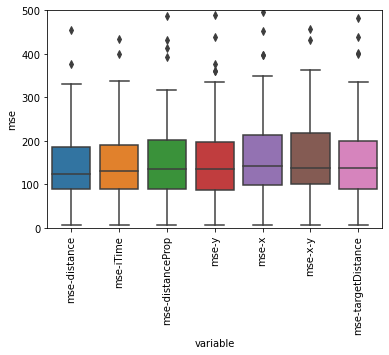

In [26]:
sns.boxplot(x="variable",y="mse",data=dfL)
plt.ylim(0,500)
plt.xticks(rotation=90)

This boxplot is not the best way to show these effects as we want to use a within-cell type of plot.

In [25]:
res.median()

/tmp/ipykernel_172133/1991015313.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  res.median()


test_n                       20.000000
train_n                      39.000000
distance_mse_train          115.372593
distance_mse_test           124.781558
iTime_mse_train             113.033506
iTime_mse_test              130.834493
distanceProp_mse_train      123.127702
distanceProp_mse_test       135.402810
y_mse_train                 118.057826
y_mse_test                  136.224946
x_mse_train                 128.050816
x_mse_test                  142.679978
x-y_mse_train               111.514063
x-y_mse_test                137.726732
targetDistance_mse_train    130.804361
targetDistance_mse_test     137.136519
dtype: float64

In [27]:
from scipy.stats import wilcoxon

def mse_plot(ax,refVar,var,res,myDict,maxVal=500):
    """
    Plot the mean square error of two models against each other
    """
    dx=res["{}_mse_test".format(refVar)]
    dy=res["{}_mse_test".format(var)]
    ax.scatter(dx,dy,s=5)
    ax.set_xlabel(myDict[refVar]["name"])
    ax.set_ylabel(myDict[var]["name"])
    ax.set_xlim(0,maxVal)
    ax.set_ylim(0,maxVal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([0,maxVal],[0,maxVal],color="grey",linestyle="--")
    st,pval = wilcoxon(dx-dy)
    median = np.median(dx-dy)
    ax.text(50,400,"p: {:.02}".format(pval))
    ax.text(50,450,"median: {:.02f}".format(median))

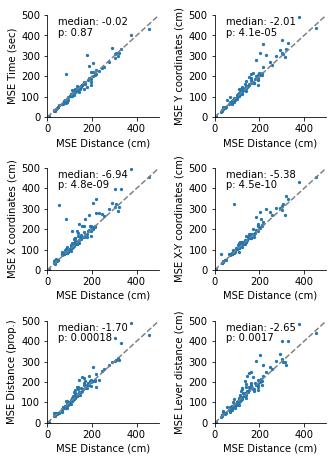

In [29]:

col=2
row=3
sizePerCol=2.5
sizePerRow=2.5
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=False) # create the overall figure to put all the axes on
gsIn = fig.add_gridspec(nrows=1, ncols=1)


gsDist = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=gsIn[0],wspace=0.5,hspace=0.5)

myDict={"distanceProp":{"name":"MSE Distance (prop.)"},
       "y":{"name":"MSE Y coordinates (cm)"},
        "x":{"name":"MSE X coordinates (cm)"},
        "x-y":{"name":"MSE X-Y coordinates (cm)"},
       "iTime":{"name":"MSE Time (sec)"},
       "targetDistance":{"name":"MSE Lever distance (cm)"},
       "distance":{"name":"MSE Distance (cm)"}}

refVar = "distance"
for i,var in enumerate(["iTime", "y","x","x-y","distanceProp", "targetDistance"]):
    x = int(i/col)
    y = i % col
    ax = fig.add_subplot(gsDist[x,y])
    mse_plot(ax,refVar,var,res,myDict,maxVal=500)